# 1. Point Cloud from Depth

*"One of the key problems in computer vision is recovering the three dimensional structure of a scene from it's images."*

In this notebook, we will learn how to compute point clouds from a depth image without using the Open3D library.

In [2]:
#imports
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 1.1 Depth Image

* A depth image (also called a depth map) is an image where each pixel provides its distance value relative to the sensor's coordinate system.<br><br>
* Depth images can be captured by structured light or time-of-flight sensors.<br><br>
  * **Structured Light Sensors**: To compute depth data, they compare the distortion between projected and recieved light. e.g. **Microsoft Kinect V1**
  * **Time-of-flight Sensors**: Project light rays and then compute the time elapsed between the projection and the reception of these later. e.g. **MS Kinect V2**

In [3]:
depth_image = iio.imread('data/depth.png')

# print properties of the depth image
print(f"Resolution: {depth_image.shape}")
print(f"Data type: {depth_image.dtype}")
print(f"Min value: {np.min(depth_image)}")
print(f"Max value: {np.max(depth_image)}")

Resolution: (480, 640)
Data type: uint16
Min value: 0
Max value: 2980


The depth image is a matrix of size 640x480 where each pixel is a 16 bit integer that represents the **distance in millimeters**. The min value 0 represents noise (there is no distance) while the max value 2980 represents the distance of the farthest pixels.

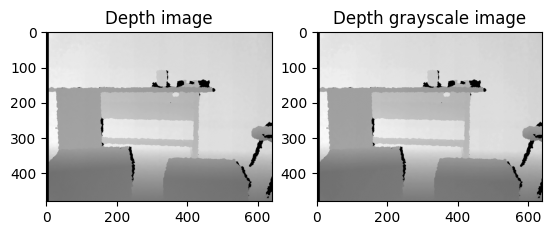

In [4]:
# scaling the depth values to [0, 255] to visualize
depth_intensity = np.array(depth_image/0x0FFF * 255, dtype=np.uint8)
# Note that matplotlib does the same thing when visualizing the depth image.

# Here 0x0FFF represents a 12 bit integer stored in a 16 bit container.
# The Kinect V1 sensor stores depth values in 16 bit integers but only
# the last 12 bits represent the actual depth. The upper 4 bits (0xF000)
# may be reserved, unused, or encode something else (e.g., confidence, flags)

if not os.path.exists('output/grayscale.png'):
    iio.imwrite('output/grayscale.png', depth_intensity)

# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(depth_intensity, cmap="gray")
axs[1].set_title('Depth grayscale image')
plt.show()

### 1.2 Point Cloud

Steps to estimate point cloud from depth image:<br><br>
1. Caliberate the depth camera to estimate the **camera matrix**.
2. Use it to compute the point cloud.


The obtained point cloud is also called **2.5D point cloud** since it is estimated from a 2D projection (depth image) instead of 3D sensors.

#### 1.2.1 Depth Camera Calibration

Calibrating a camera means estimating lens and sensor parameters by finding the distortion coefficients and the camera matrix also called the intrinsic parameters.<br><br>

In general, there are three methods for calibrating a camera:
* Using the standard parameters provided by the factory
* Using the results obtained in calibration research
* Calibrating the Kinect manually.

Calibrating the camera manually consists of applying one of the calibration algorithm such as the chess-board algorithm. This algorithm is implemented in Robot Operating System (ROS) and OpenCV. [Reference](https://docs.opencv.org/4.6.0/dc/dbb/tutorial_py_calibration.html).


The calibration  matrix:
$$
M = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}\\
$$


Where $f_x, f_y$ and $c_x, c_y$ are the focal length and the optical centers (intrinsic parameters)
<div style="text-align: center;">
  <img src="./images/sensor.png" alt="Description" width="50%"/>
</div>




In [5]:
# Depth Camera parameters (intrinsic parameters)
FX_DEPTH = 5.8262448167737955e+02 # focal length (mm) * pixel density in x direction (m_x:pixels/mm)
FY_DEPTH = 5.8269103270988637e+02 # focal length (mm) * pixel density in y direction (m_y:pixels/mm)
CX_DEPTH = 3.1304475870804731e+02 # x coordinate of the optical center in the image plane
CY_DEPTH = 2.3844389626620386e+02 # y coordinate of the optical center in the image plane

#### 1.2.2 Point Cloud Computing

Using the calibration matrix we go from 3D (Camera Coordinate System) to 2D (Image Plane). This is called **perspective projection**.

Image Plane Coordinates(in pixels):
$\textbf{u} = \begin{bmatrix}
u \\
v
\end{bmatrix}$

Homogeneous coordinates of $\textbf{u}$:
$\tilde{\textbf{u}} = \begin{bmatrix}
u \cdot z_c \\
v \cdot z_c \\
z_c
\end{bmatrix}$

Camera Frame Coordinates (Point Cloud Coordinates):
$\textbf{x}_c = \begin{bmatrix}
x_c \\
y_c \\
z_c
\end{bmatrix}$

Perspective Projection:
$M \cdot \textbf{x}_c = \tilde{\textbf{u}}$

The matrix multiplication above gives us three equations:
$$\begin{align}
f_x \cdot x_c + c_x \cdot z_c &= u \cdot z_c \\
f_y \cdot y_c + c_y \cdot z_c &= v \cdot z_c \\
z_c &= z_c
\end{align}$$
Solving for camera coordinates:$$\begin{align}
x_c &= z_c \cdot \frac{(u - c_x)}{f_x} \\
y_c &= z_c \cdot \frac{(v - c_y)}{f_y}
\end{align}$$

Where:
- $z_c$ is the depth intensity at $(u, v)$ in the depth image
- $u$ and $v$ are the pixel coordinates in the depth image

In [53]:
# formula applied for each pixel
pcd = []
h, w = depth_image.shape

for i in range(h):
    for j in range(w):
        z = depth_image[i][j]
        x = z * (j - CX_DEPTH) / FX_DEPTH
        y = z * (i - CY_DEPTH) / FY_DEPTH
        pcd.append([x, y, z])

In [54]:
# Visualize using o3d
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(np.asarray(pcd))
o3d.visualization.draw_geometries([pcd_o3d])

### 1.3 Colored Point Cloud

 A colored point cloud can be defined as follows:

$$ PCD = \{(\mathbf{p}_i) | i=1, 2, \dots, N\}$$
$$\mathbf{p_i} = \begin{bmatrix} x_i \\ y_i \\ z_i \\ r_i \\ g_i \\ b_i \end{bmatrix}$$

Where $x$, $y$ and $z$ are the 3D coordinates and $r$, $g$ and $b$ represent the color in the RGB system.


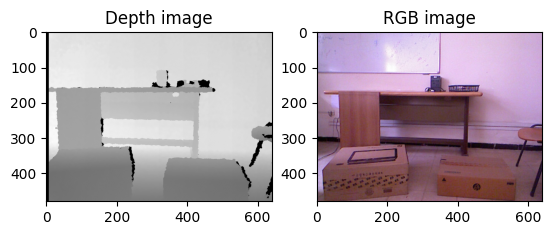

In [7]:
# Read the rgb image:
rgb_image = iio.imread('./data/rgb.jpg')

# Display depth and rgb image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(rgb_image)
axs[1].set_title('RGB image')
plt.show()

In the above system there are two cameras:

1. Depth Image Sensor Camera
2. RGB Image Sensor Camera

So to get the color information of our point cloud which is in the depth image sensor camera coordinates we need to do the following transformations:

#### 1.3.1 Tranform the point $p(x, y, z)$ defined in the depth sensor 3D coordinate system to the RGB camera coordinate system:

$$
\begin{bmatrix}
x_{rgb} \\ y_{rgb} \\ z_{rgb} \end{bmatrix} = R^{-1} \cdot \begin{bmatrix} x_{depth} \\ y_{depth} \\ z_{depth} \end{bmatrix} + R^{-1} \cdot T
$$

Where $R$ is the rotation matrix and $T$ is the translation vector. These are the **extrinsic parameters** of the depth camera relative to the RGB camera. The columns of $R$ are the basis vectors of the depth camera coordinate system expressed in the RGB camera coordinate system.


<div style="text-align: center;">
  <img src="./images/wcs_to_ccs.png" alt="Description" width="50%"/>
</div>


In [49]:
# Rotation matrix:
R = np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
# Translation vector:
T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])

In [50]:
def transform_coordinates(X, R, T):
    """
    Converts the point from depth sensor 3D coordinates to the RGB camera 3D coordinates.

    3D to 3D

    """

    [x, y, z] = X

    [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R) @ np.array([x, y, z]) + np.linalg.inv(R) @ T

    return [x_RGB, y_RGB, z_RGB]

#### 1.3.2 Using the intrinsic parameters of the RGB camera, we can project the point to the RGB image plane:

$$
\begin{aligned}
x_{rgb} &= \frac{x_{RGB} \times f^x_{RGB}}{z_{RGB}} + c^x_{RGB} \\
y_{rgb} &= \frac{y_{RGB} \times f^y_{RGB}}{z_{RGB}} + c^y_{RGB}
\end{aligned}
$$


Where $f^x_{RGB},  f^y_{RGB}, c^x_{RGB}, c^y_{RGB}$ are the intrinsic parameters of the RGB camera.

These are the indices to get the color pixel

In [51]:
# RGB camera intrinsic Parameters:
FX_RGB = 5.1885790117450188e+02
FY_RGB = 5.1946961112127485e+02
CX_RGB = 3.2558244941119034e+0
CY_RGB = 2.5373616633400465e+02

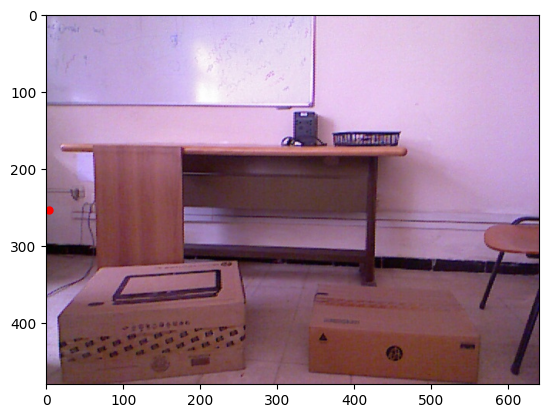

In [73]:
plt.imshow(rgb_image)
plt.plot([CX_RGB], [CY_RGB], 'ro', markersize=5)

In [61]:
def perspective_projection(X, FX, FY, CX, CY):
    """
    Converts the 3D point to 2D pixel coordinates.

    3D to 2D
    """
    [x, y, z] = X

    u = int((FX * x) / z + CX) 
    v = int((FY * y) / z + CY)

    return [u, v]

In [62]:
rgb_image.shape, depth_image.shape

((480, 640, 3), (480, 640))

In [63]:
# Putting it all together:
colors = []
pcd = []

for i in range(h):
    for j in range(w):
        z = depth_image[i][j]
        x = z * (j - CX_DEPTH) / FX_DEPTH
        y = z * (i - CY_DEPTH) / FY_DEPTH
        
        # Transform to RGB camera coordinates
        X_RGB = transform_coordinates([x, y, z], R, T)
        
        # Project to pixel coordinates in RGB image
        [u, v] = perspective_projection(X_RGB, FX_RGB, FY_RGB, CX_RGB, CY_RGB)
        
        if u < w and v < h and u >= 0 and v >= 0:
            colors.append(rgb_image[u][v]/255)
        else:
            colors.append([0, 0, 0])
        
        pcd.append([x, y, z])

In [69]:
count = 0

for i in range(len(colors)):
    if colors[i][0] == 0 and colors[i][1] == 0 and colors[i][2] == 0:
        count += 1
count/len(colors)

0.49785807291666667

In [56]:
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])